In [1]:
import os
import glob
import random
import numpy as np
import matplotlib. image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchvision import transforms

/home/dkrz/k202143/miniconda3/envs/gen_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_img = "data/CamSeq_2007/images"
path_mask = "data/CamSeq_2007/masks"

# read all images and plot 20 random images with masks
images = glob.glob(f"{path_img}/*")
masks = glob.glob(f"{path_mask}/*")

images.sort()
masks.sort()

print(images[:5])
print(masks[:5])

['data/CamSeq_2007/images/0016E5_07959.png', 'data/CamSeq_2007/images/0016E5_07961.png', 'data/CamSeq_2007/images/0016E5_07963.png', 'data/CamSeq_2007/images/0016E5_07965.png', 'data/CamSeq_2007/images/0016E5_07967.png']
['data/CamSeq_2007/masks/0016E5_07959_L.png', 'data/CamSeq_2007/masks/0016E5_07961_L.png', 'data/CamSeq_2007/masks/0016E5_07963_L.png', 'data/CamSeq_2007/masks/0016E5_07965_L.png', 'data/CamSeq_2007/masks/0016E5_07967_L.png']


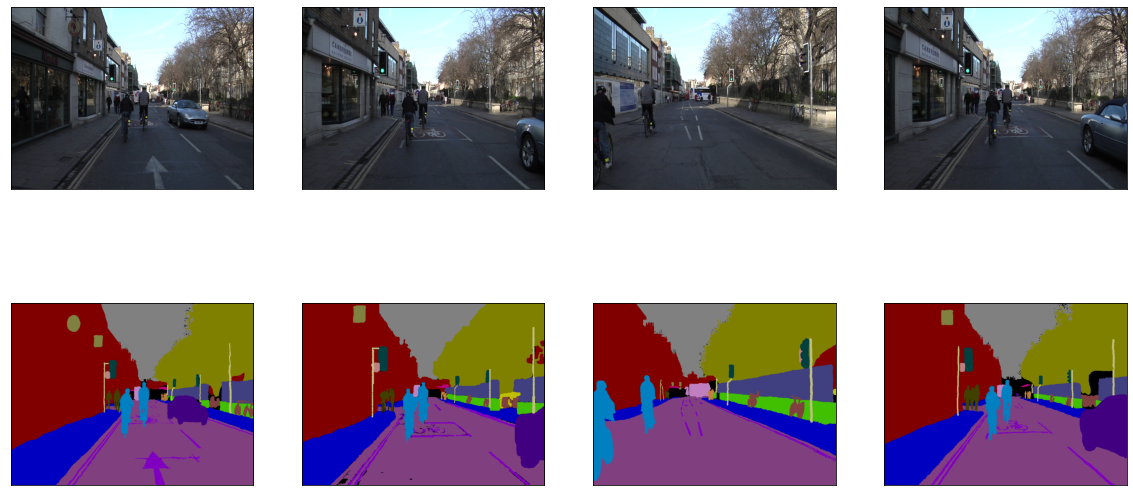

In [3]:
# select 20 random indices for the images
idxs_all = np.arange(len(images))
idxs_sel = random.choices(idxs_all, k=10)
fig, axes = plt.subplots(2, 4, figsize=(20,10))

for i in range(4):
    img = mpimg.imread(images[idxs_sel[i]])
    mask = mpimg.imread(masks[idxs_sel[i]])
 
    axes[0,i].imshow(img)
    axes[1,i].imshow(mask)
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([]);

In [4]:
# adapt code for preprocessing from
# https://www.kaggle.com/code/yauhenikavaliou/camseq-semantic-segmentation

In [5]:
color_codes = {
    'Animal': [64, 128, 64],
    'Archway': [192, 0, 128],
    'Bicyclist': [0, 128, 192],
    #'Bridge': [0, 128, 64],
    'Building': [128, 0, 0],
    'Car': [64, 0, 128],
    'CartLuggagePram': [64, 0, 192],
    'Child': [192, 128, 64], 
    'Column_Pole': [192, 192, 128],
    'Fence': [64, 64, 128],
    'LaneMkgsDriv': [128, 0, 192],
    #'LaneMkgsNonDriv': [192, 0, 64],
    'Misc_Text': [128, 128, 64],
    #'MotorcycleScooter': [192, 0, 192],
    'OtherMoving': [128, 64, 64],
    #'ParkingBlock': [64, 192, 128],
    'Pedestrian': [64, 64, 0],
    'Road': [128, 64, 128],
    #'RoadShoulder': [128, 128, 192],
    'Sidewalk': [0, 0, 192],
    'SignSymbol': [192, 128, 128],
    'Sky': [128, 128, 128],
    #'SUVPickupTruck': [64, 128, 192],
    #'TrafficCone': [0, 0, 64],
    'TrafficLight': [0, 64, 64],
    #'Train': [192, 64, 128],
    'Tree': [128, 128, 0],
    'Truck_Bus': [192, 128, 192],
    #'Tunnel': [64, 0, 64],
    'VegetationMisc': [192, 192, 0],
    'Void': [0, 0, 0],
    'Wall': [64, 192, 0]
}

In [6]:
print(f'Number of classes: {len(color_codes.keys())}')

Number of classes: 23


In [7]:
NEW_SIZE = (256, 256)
#PATH = '/kaggle/input/camseq-semantic-segmentation/'
path_img = "data/CamSeq_2007/images"
path_mask = "data/CamSeq_2007/masks"
N_CLASSES = len(color_codes.keys())

In [8]:
def arrays_from_single_folder(path=path_img, new_size=NEW_SIZE):  
    images = []
   
    filenames = os.listdir(path)
    filenames.sort()
    for filename in filenames:
        path_to_img = os.path.join(path, filename)
        
        img = cv2.imread(path_to_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, new_size) 
        #img = img / 255.0
        images.append(img)
        
    return images

In [9]:
def get_mask_channels(mask, color_codes):
    n_channels = len(color_codes.keys())  # N_CLASSES
    mask_channels = np.zeros((mask.shape[0], mask.shape[1], n_channels), 
                             dtype=np.float32)
    for i, cls in enumerate(color_codes.keys()):
        color = color_codes[cls]
        sub_mask = np.all(mask==color, axis=-1) * i
        mask_channels[:, :, i] = sub_mask
    return mask_channels

In [10]:
def get_masks_one_hot(mask, color_codes):
    n_channels = len(color_codes.keys())  # N_CLASSES
    mask_channels = np.zeros((mask.shape[0], mask.shape[1], n_channels), 
                             dtype=np.float32)
    for i, cls in enumerate(color_codes.keys()):
        color = color_codes[cls]
        sub_mask = np.all(mask==color, axis=-1) * 1
        mask_channels[:, :, i] = sub_mask
    return mask_channels

In [11]:
images = arrays_from_single_folder(path_img, NEW_SIZE)
masks = arrays_from_single_folder(path_mask, NEW_SIZE)
#print(images[0])
#print(masks[0])
masks_channels = [get_mask_channels(mask, color_codes) for mask in masks]

masks_one_hot = [get_masks_one_hot(mask, color_codes) for mask in masks]

In [12]:
# classes 3, 11, 13, 15, 25, 28 are absent in the dataset (those classes were commented in 'color_codes')
print('masks_channels: ', np.unique(masks_channels))
# check masks_one_hot variable (in must consist of 0 and 1)
print('masks_one_hot: ', np.unique(masks_one_hot))

masks_channels:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22.]
masks_one_hot:  [0. 1.]


In [13]:
print(masks_channels[0].shape)
print(len(masks_channels))

(256, 256, 23)
101


In [58]:
print(masks_one_hot[0].shape)
print(len(masks_one_hot))

(256, 256, 23)
101


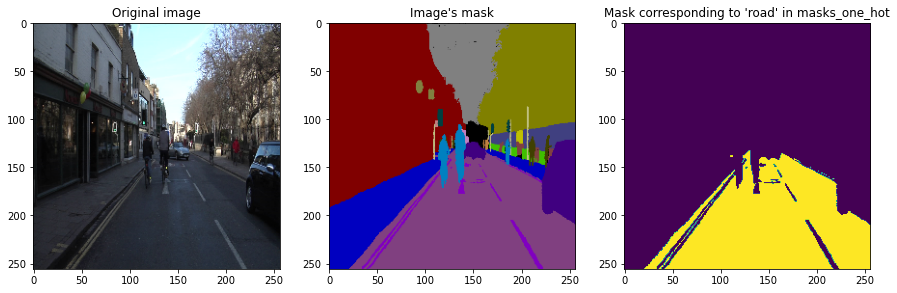

In [59]:
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.imshow(images[7])
plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(masks[7])
plt.title("Image's mask")
plt.subplot(1,3,3)
plt.imshow(masks_one_hot[7][:, :, 13]) ## road
plt.title("Mask corresponding to 'road' in masks_one_hot")
plt.show()

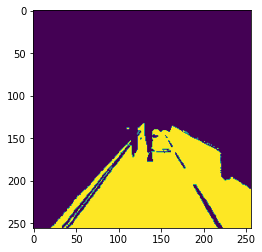

In [60]:
plt.imshow(masks_channels[7][:,:,13]);

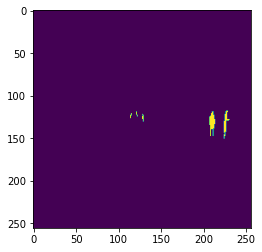

In [61]:
plt.imshow(masks_one_hot[7][:,:,12]);

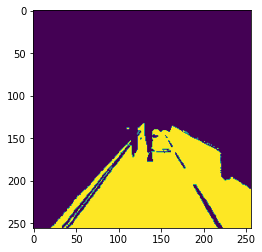

In [62]:
plt.imshow(masks_one_hot[7][:, :, 13]);